In [18]:
import os
import torch
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt
import numpy as np

from detr_config import Config
from detr_dataset import InBreastDataset, get_test_dataset, detr_processor
from detr_model import DETRModel

In [43]:
model = DETRModel.load_from_checkpoint(
    './lightning_logs/queries=10_dmodel=64_layers=2/fold_1/checkpoints/epoch=33-step=170.ckpt'
)

## Detect

In [44]:
def plot_results(image, scores, labels, boxes):
    draw = ImageDraw.Draw(image, "RGBA")

    for score, label, (x, y, xf, yf) in zip(scores.tolist(), labels.tolist(), boxes.tolist()):
        draw.rectangle((x, y, xf, yf), outline='red', width=2)
        id2label = model.detr_model.config.id2label
        text = f'{np.round(score, 2)} - {id2label[label]}'
        draw.text((x, y), text, fill='red', 
                  font=ImageFont.truetype("arial.ttf", 20))

    plt.figure(figsize=(4,4))
    plt.axis("off")
    plt.imshow(image)

In [45]:
test_dataset = get_test_dataset()

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


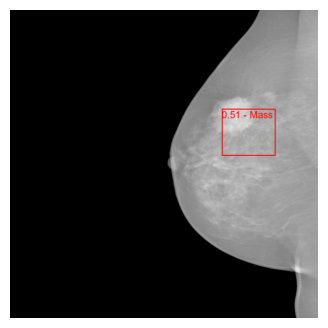

In [51]:
pixel_values, labels = test_dataset.__getitem__(4)
image_id = labels['image_id'].item()
image_data = test_dataset.coco.loadImgs(image_id)[0]
image = Image.open(os.path.join(Config.TEST_DIRECTORY, image_data['file_name']))

with torch.no_grad():
    model.eval()
    outputs = model(pixel_values=pixel_values.unsqueeze(0))

postprocessed_outputs = detr_processor.post_process_object_detection(outputs,
                                                                     target_sizes=[(640, 640)],
                                                                     threshold=0.51)
results = postprocessed_outputs[0]
plot_results(image, results['scores'], results['labels'], results['boxes'])